## Final Project - Introduction to Machine Learning @ UBC

#
# Predicting Lower Fat Content in Canadian Cheeses
######
#### Paramjit Hothi, March 2023
####
### Introduction

Using machine learning techniques we create different models, select the optimal model, evaluate the results of the optimal model and test on test data.

### Data Source
Data used for this analysis was provided by the UBC Introduction to Machine Learning course. As per the course project instructions the original data was found "on the Government of Canada's Open Government Portal but has unfortunately been taken down."

### The Data

#### Import modules

In [1]:
# Import libraries needed for this analysis
from hashlib import sha1

import altair as alt
#import graphviz
import numpy as np
import pandas as pd
import io

pd.set_option('display.max_columns', None)

#### Create function to display data_frame.info() in a pretty table

Reference: [Tabulated_Info()](https://stackoverflow.com/questions/70748529/how-to-save-pandas-info-function-output-to-variable-or-data-frame)

In [2]:
# Define new function to display dataframe.info() is a pretty format
def pretty_info(input_df: 'dataframe'):

    buffer = io.StringIO()
    input_df.info(buf = buffer)
    lines = buffer.getvalue().splitlines()
    df = (pd.DataFrame([x.split() for x in lines[5:-2]], columns = lines[3].split())
          .drop('Count', axis = 1)
          .rename(columns={'Non-Null':'Non-Null Count'}))
    
    return df

#### Read our data file

In [3]:
cheese = pd.read_csv('data/cheese_data.csv')
display("We have " + str(cheese.shape[1]) + " columns and " + str(cheese.shape[0])+  " records")

'We have 13 columns and 1042 records'

The data has 13 columns (sorted alphabetically): 

CategoryTypeEn, CharacteristicsEn, CheeseId, CheeseName, FatLevel, FlavourEn, ManufacturerProvCode, ManufacturingTypeEn, MilkTreatmentTypeEn, MilkTypeEn, MoisturePercent, Organic and RindTypeEn

We **drop** two columns that we are not used in our analysis:
- CheeseId - an identifier
- RindTypeEn - describes the rind of the cheese, dropped as too many missing values and not used by the course in their analysis 

In [4]:
cheese.drop(columns = ['CheeseId', 'RindTypeEn'], inplace = True)

####
#### **Target Column**
Our **target** column, the one will will predict, is FatLevel:
- FatLevel, has two values 'Lower-Fat' and 'Higher-Fat'

####
We **group** the remaining ten columns into three groups:
- numercial_columns (2)
- categorical_columns (5)
- text_columns (3)

These groupings will be used in our modelling analysis

####
#### **numerical_columns**

There are two numerical columns:
- MoisturePercent
- Organic

In [5]:
numerical_columns = ['MoisturePercent', 'Organic']

In [6]:
pretty_info(cheese[numerical_columns]).style.set_caption("Fig 1: Cheese Numercial Columns")

,#,Column,Non-Null Count,Dtype
0,0,MoisturePercent,1028,float64
1,1,Organic,1042,int64


####
Basic statistics for the numerical columns are shown below.

Organic, has two values 0 and 1. Value 1 indicating the cheese is of 0rganic type and 0 for not organic type

In [7]:
display(cheese[numerical_columns].describe().style.set_caption(
    "Fig 2: Basic Statistics for Numercial Coolumns"))

,MoisturePercent,Organic
count,1028.000000,1042.000000
mean,47.069747,0.095010
std,9.592647,0.293369
min,12.000000,0.000000
25%,40.000000,0.000000
50%,46.000000,0.000000
75%,52.000000,0.000000
max,92.000000,1.000000


####
Majority of the cheeses are organic as can be see in Fig 1.

In [8]:
base = (alt.Chart(cheese, width=100, height=100).mark_bar()
          .encode(
              alt.Y('Organic:N', sort = 'x'),
              alt.X('count():Q', title = 'Count'),
              tooltip = [alt.Tooltip('count():Q'),
                        alt.Tooltip('Organic:N')]
          )
          .properties(title = 'Fig 3. Count of Unique Values in Organic')
         )

Fig_3 = base + base.mark_text(align ='left', dx = 2).encode(text = 'count():Q')

Fig_3

alt.LayerChart(...)

####
#### **categorical_columns**

There are five categorical columns:
- CategoryTypeEn
- ManufacturerProvCode
- ManufacturingTypeEn
- MilkTreatmentTypeEn
- MilkTypeEn

In [9]:
categorical_columns = ['CategoryTypeEn', 'ManufacturerProvCode', 'ManufacturingTypeEn', 
                       'MilkTreatmentTypeEn', 'MilkTypeEn']

####
The number of unique values in each categorical column is shown in the graph below - Fig 2.

In [10]:
df = pd.DataFrame(cheese[categorical_columns].nunique()).reset_index()
df.columns = ['column', 'unique_count']

Fig_4 = (alt.Chart(df).mark_bar().encode(
        alt.Y('column:N', sort = '-x', title = 'Column Name'),
        alt.X('unique_count:Q', title = 'Count'))
          .properties(title = 'Fig 4: Number of Unique Values in each Column')
         )
Fig_4

alt.Chart(...)

####
In Fig 3 below, for each categorical column we display a horizontal bar chart showing the unique values as the rows and the count of cheese rows on the x-axis. 

Reference: [altair.repeat example](https://github.com/altair-viz/altair/issues/1133)

**Observations from Fig 3:**

- Most of the cheese comes from Quebec(QC)
- Industrial is the highest manufacturing type
- Firm cheese is the highest category type
- Cow and goat milk types account for most of the cheeses
- Most milk is pasteurized

In [11]:
Fig_5 = (alt.Chart(cheese, width=100, height=100).mark_bar()
          .encode(
              alt.Y(alt.repeat('repeat'), type = 'nominal', sort = 'x'),
              alt.X('count():Q', title = 'Count')          
          )
          .repeat(
              repeat = categorical_columns, 
              columns = 3)
          .properties(title = 'Fig 5. Count of Unique Values in Columns')
         )
Fig_5

# Reference: Acknowledgement - https://github.com/altair-viz/altair/issues/1133

alt.RepeatChart(...)

####
Fig 6. Missing Data Count table


In [12]:
display(pretty_info(cheese[categorical_columns]).style.set_caption(
    "Fig 6: Info for Categorical Columns"))

,#,Column,Non-Null Count,Dtype
0,0,CategoryTypeEn,1019,object
1,1,ManufacturerProvCode,1042,object
2,2,ManufacturingTypeEn,1042,object
3,3,MilkTreatmentTypeEn,977,object
4,4,MilkTypeEn,1041,object


####
From Fig 5 and Fig 6, we observe the following categorical columns are **missing data** (format is name, number of rows):
- CategoryTypeEn, 23
- MilkTypeEn, 1
- MilkTreatmentTypeEn, 65
 

In our modelling we will consider **imputing** these missing values.

####
#### **text_columns**

There are three text columns:
- CharacteristicsEn
- CheeseName
- FlavourEn


In [13]:
text_columns = ['CharacteristicsEn', 'CheeseName', 'FlavourEn']

We have included **CheeseName** as a text field as the name itself may help to predict.

####
We replace NaN with '' in the text fields

In [14]:
for col in ['FlavourEn', 'CharacteristicsEn', 'CheeseName']:
    cheese[col] = cheese[col].fillna('')

####
#### Duplicates in CheeseName column
We note there are four **duplicate** names in the 'CheeseName' column. We make note but do not modify the data

In [15]:
cheese['CheeseName'].nunique() == cheese.shape[0]

False

In [16]:
cheese['CheeseName'].nunique()

1038

In [17]:
duplicate_rows = cheese[cheese.duplicated(['CheeseName'])]

table = (cheese[cheese['CheeseName'].isin(duplicate_rows['CheeseName'])]
         .sort_values(['CheeseName']))

display(table.style.set_caption("Fig 6: Info for Categorical Columns"))

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,CheeseName,FatLevel
70,BC,Artisan,43.000000,,,0,Firm Cheese,Cow,Pasteurized,Boerenkaas,higher fat
907,BC,Artisan,43.000000,Available smoked,,0,Firm Cheese,Cow,nan,Boerenkaas,higher fat
947,NB,Farmstead,50.000000,Mild taste becoming stronger with age.,,0,Firm Cheese,Goat,Pasteurized,Cheddar,lower fat
967,QC,Farmstead,39.000000,,,1,Hard Cheese,Cow,nan,Cheddar,higher fat
948,NB,Farmstead,50.000000,Light and salty.,,0,Fresh Cheese,Goat,Pasteurized,Fromage en grain,lower fat
995,QC,Artisan,41.000000,Lightly salted,,0,Fresh Cheese,Cow,Pasteurized,Fromage en grain,higher fat
694,QC,Artisan,36.000000,"Cream, hazelnut, flowers and smoky flavor","Pressed and cooked, golden to copper-colored rind",1,Firm Cheese,Cow,Raw Milk,Ménestrel (Le),higher fat
928,QC,Farmstead,36.000000,,,0,Firm Cheese,Cow,Pasteurized,Ménestrel (Le),higher fat


##
## Challenge Statement

Can we predict the fat level (column **FatLevel**) from the other columns in the data?

####
This challenge is important as fat level is an important consideration in selecting cheese in our health conscience society.


##
## Analysis

#### In terms of machine learning terminology:

- We have a **classification** problem
- We have a **binary** classification problem as the outcome is either lower-fat or higher-fat
- Our **positive label** for our binary classification problem is **lower-fat**

####
Supervised models for classification problem analysis included:
- **Logistic Regression** - LogisticRegression()
- **Decision Tree** - DecisionTreeClassifier()
- **Support Vector Classifier** - SVC()
- **K-Nearest Neighbour** - KNeighborsClassifier()
- **Random Forest** - RandomForestClassifier()


    

####
#### For completeness, we will re-do steps:
- Import modules
- Read data file
- Drop columns CheeseId and RindTypeEnreplac
- Replace NAN with '' in text_columns


In [18]:
# Import libraries needed for this analysis
from hashlib import sha1

# Basic modules
import numpy as np
import pandas as pd
import io

pd.set_option('display.max_columns', None)

# Graphing
import altair as alt


# Machine modelling - sklearn
from sklearn import preprocessing
from sklearn import tree

from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer

from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier

from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer 


In [19]:
# Read data
cheese = pd.read_csv('data/cheese_data.csv')

# Drop columns
cheese.drop(columns = ['CheeseId', 'RindTypeEn'], inplace = True)

#Replace NAN with '' in text columns
text_columns = ['CharacteristicsEn', 'CheeseName', 'FlavourEn']
for col in text_columns:
    cheese[col] = cheese[col].fillna('')

####
#### Create pretty_info function

to display dataframe.info() in a pretty format

In [20]:
# Define new function to display dataframe.info() in a pretty format
def pretty_info(input_df: 'dataframe'):
    buffer = io.StringIO()
    input_df.info(buf = buffer)
    lines = buffer.getvalue().splitlines()
    df = (pd.DataFrame([x.split() for x in lines[5:-2]], columns = lines[3].split())
          .drop('Count', axis = 1)
          .rename(columns={'Non-Null':'Non-Null Count'}))
    return df

####
#### Convert column Organic to object
- as it is already binary and we don't want to treat it like a numeric

In [21]:
cheese['Organic'] = cheese['Organic'].astype("object")

####
#### View of cheese data

In [22]:
display(cheese.head().style.set_caption("Fig 7: Cheese Data"))

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,CheeseName,FatLevel
0,NB,Farmstead,47.000000,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Sieur de Duplessis (Le),lower fat
1,NB,Farmstead,47.900000,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Tomme Le Champ Doré,lower fat
2,ON,Industrial,54.000000,"Mild, tangy, and fruity","Pressed and cooked cheese, pasta filata, interiror ripened",0,Firm Cheese,Cow,Pasteurized,Provolone Sette Fette (Tre-Stelle),lower fat
3,NB,Farmstead,47.000000,Sharp with fruity notes and a hint of wild honey,,0,Veined Cheeses,Cow,Raw Milk,Geai Bleu (Le),lower fat
4,NB,Farmstead,49.400000,Softer taste,,1,Semi-soft Cheese,Cow,Raw Milk,Gamin (Le),lower fat


In [23]:
display(pretty_info(cheese).style.set_caption("Fig 8: Cheese Info()"))

,#,Column,Non-Null Count,Dtype
0,0,ManufacturerProvCode,1042,object
1,1,ManufacturingTypeEn,1042,object
2,2,MoisturePercent,1028,float64
3,3,FlavourEn,1042,object
4,4,CharacteristicsEn,1042,object
5,5,Organic,1042,object
6,6,CategoryTypeEn,1019,object
7,7,MilkTypeEn,1041,object
8,8,MilkTreatmentTypeEn,977,object
9,9,CheeseName,1042,object


####
#### Create new text columns

In [24]:
#Create new combinations text fields
cheese['CharacteristicsEn_CheeseName'] = cheese['CharacteristicsEn'] + cheese['CheeseName']
cheese['CharacteristicsEn_FlavourEn'] = cheese['CharacteristicsEn'] + cheese['FlavourEn']
cheese['CheeseName_FlavourEn'] = cheese['CheeseName'] + cheese['FlavourEn']
cheese['CharacteristicsEn_CheeseName_FlavourEn'] = (cheese['CharacteristicsEn'] +
                                                    cheese['CheeseName'] + 
                                                    cheese['FlavourEn'])

####
#### Create variables

Note: Organic is now a categorical column


In [25]:
numerical_columns = ['MoisturePercent']
categorical_columns = ['CategoryTypeEn', 'ManufacturerProvCode', 'ManufacturingTypeEn', 
                       'MilkTreatmentTypeEn', 'MilkTypeEn', 'Organic']
text_columns = ['CharacteristicsEn', 'CheeseName', 'FlavourEn']
text_columns_new =  ['CharacteristicsEn_CheeseName', 'CharacteristicsEn_FlavourEn',
                      'CheeseName_FlavourEn', 'CharacteristicsEn_CheeseName_FlavourEn'] 
text_columns_combined = text_columns + text_columns_new

####
#### Column Transform FatLevel - onehotcode

In [26]:
label = preprocessing.LabelEncoder() 
cheese['FatLevel']= label.fit_transform(cheese['FatLevel'])
display((cheese[['FatLevel']].head(15)).style.set_caption("Fig 9. Fat Level Column Contains 0's and 1's"))

,FatLevel
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [27]:
display(pretty_info(cheese).style.set_caption("Fig 10. Cheese: Column Data Type, Non-Null Count"))

,#,Column,Non-Null Count,Dtype
0,0,ManufacturerProvCode,1042,object
1,1,ManufacturingTypeEn,1042,object
2,2,MoisturePercent,1028,float64
3,3,FlavourEn,1042,object
4,4,CharacteristicsEn,1042,object
5,5,Organic,1042,object
6,6,CategoryTypeEn,1019,object
7,7,MilkTypeEn,1041,object
8,8,MilkTreatmentTypeEn,977,object
9,9,CheeseName,1042,object


####
#### View of cheese data with the additional text columns

In [28]:
display(cheese.head().style.set_caption("Fig 11: Cheese Data"))

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,CheeseName,FatLevel,CharacteristicsEn_CheeseName,CharacteristicsEn_FlavourEn,CheeseName_FlavourEn,CharacteristicsEn_CheeseName_FlavourEn
0,NB,Farmstead,47.000000,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Sieur de Duplessis (Le),1,UncookedSieur de Duplessis (Le),"UncookedSharp, lactic","Sieur de Duplessis (Le)Sharp, lactic","UncookedSieur de Duplessis (Le)Sharp, lactic"
1,NB,Farmstead,47.900000,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Tomme Le Champ Doré,1,UncookedTomme Le Champ Doré,"UncookedSharp, lactic, lightly caramelized","Tomme Le Champ DoréSharp, lactic, lightly caramelized","UncookedTomme Le Champ DoréSharp, lactic, lightly caramelized"
2,ON,Industrial,54.000000,"Mild, tangy, and fruity","Pressed and cooked cheese, pasta filata, interiror ripened",0,Firm Cheese,Cow,Pasteurized,Provolone Sette Fette (Tre-Stelle),1,"Pressed and cooked cheese, pasta filata, interiror ripenedProvolone Sette Fette (Tre-Stelle)","Pressed and cooked cheese, pasta filata, interiror ripenedMild, tangy, and fruity","Provolone Sette Fette (Tre-Stelle)Mild, tangy, and fruity","Pressed and cooked cheese, pasta filata, interiror ripenedProvolone Sette Fette (Tre-Stelle)Mild, tangy, and fruity"
3,NB,Farmstead,47.000000,Sharp with fruity notes and a hint of wild honey,,0,Veined Cheeses,Cow,Raw Milk,Geai Bleu (Le),1,Geai Bleu (Le),Sharp with fruity notes and a hint of wild honey,Geai Bleu (Le)Sharp with fruity notes and a hint of wild honey,Geai Bleu (Le)Sharp with fruity notes and a hint of wild honey
4,NB,Farmstead,49.400000,Softer taste,,1,Semi-soft Cheese,Cow,Raw Milk,Gamin (Le),1,Gamin (Le),Softer taste,Gamin (Le)Softer taste,Gamin (Le)Softer taste


####
#### Define X and y

In [29]:
X = cheese.drop(columns = 'FatLevel')
y = cheese['FatLevel']

####
#### Split data into traning and tes

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, random_state = 123) 

####
#### Establish base model scores



In [31]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)
dummy.score(X_test, y_test)

data = {}
data["training_score"] = [round(dummy.score(X_train, y_train), 3)]
data["test_score"] = [round(dummy.score(X_test, y_test), 3)]

dummy_scores = pd.DataFrame(data, index = ['scores'])
Fig_11 = dummy_scores.style.set_caption('Fig 11. Dummy Classifier Scores')
Fig_11

,training_score,test_score
scores,0.662000,0.640000


In [32]:
dummy = DummyClassifier()
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
pd.DataFrame(scores).mean()

fit_time       0.000300
score_time     0.000212
test_score     0.661971
train_score    0.661972
dtype: float64

###
### Numerical features, classification problem



In [33]:
cheese_drop = cheese.dropna(subset = ['MoisturePercent'])
X = cheese_drop[numerical_columns]
y = cheese_drop['FatLevel']
print(X.shape, y.shape)
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size = 0.20, random_state = 123)

(1028, 1) (1028,)


####
#### Dummy Classifier vs KNeighborsClassifier

DummyClassifier mean validation score = 0.662
KNeighborsClassifier mean validation score = 0.841

In [34]:
dummy = DummyClassifier()
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
print('Mean validation score', scores['test_score'].mean().round(3))

Mean validation score 0.662


In [35]:
knn = KNeighborsClassifier()
scores = cross_validate(knn, X_train, y_train, return_train_score=True)
print('Mean validation score', scores['test_score'].mean().round(3))

Mean validation score 0.841


####
#### Numerical Pipeline: Scaler

Scaler = StandardScaler()


#### Numerical Pipeline: Imputer

We need to impute the missing numerical values. Should we use imputer with strategy = mean or median?

Using KNeighborsClassifier lets compare when we use imputer strategy = mean vs median

In [36]:
X = cheese[numerical_columns]
print(X.shape)
y = cheese['FatLevel']
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size = 0.20, random_state = 123)

data = {}
for strategy in ['mean', 'median']:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("imputer", SimpleImputer(strategy=strategy)),
        ("knn_classifier", KNeighborsClassifier())])
    pipe.fit(X_train, y_train)    
    data[strategy] = [round(pipe.score(X_train, y_train), 3)]
    
knn_scores = pd.DataFrame(data, index = ['strategy'])
knn_scores.style.set_caption('Fig A. knn Imputer Scores')

(1042, 1)


,mean,median
strategy,0.785000,0.796000


####
We see **median** gives us a slightly higher score, so we will impute with **strategy = median**

####

####
#### Numerical Pipeline: Modeler


Which model is best: KNeighborsClassifier, DecisionTreeClassifier or LogisticRegression?

####

In [37]:
data = {}
for model in [KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() ]:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("imputer", SimpleImputer(strategy = 'median')),
        ("model", model)])
    pipe.fit(X_train, y_train)
    display(pipe.fit(X_train, y_train))
    data[model] = [round(pipe.score(X_train, y_train), 3)]    
    
knn_scores = pd.DataFrame(data, index = ['model'])
knn_scores.style.set_caption('Fig A. knn Imputer Scores')

Pipeline(steps=[('scaler', StandardScaler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('model', KNeighborsClassifier())])

Pipeline(steps=[('scaler', StandardScaler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('model', DecisionTreeClassifier())])

Pipeline(steps=[('scaler', StandardScaler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('model', LogisticRegression())])

,KNeighborsClassifier(),DecisionTreeClassifier(),LogisticRegression()
model,0.796000,0.834000,0.797000


####

We see the **DecisionTreeClassifier** gives us the higest train score, so we will use DecisionTreeClassifier

####

####
#### Numerical Pipeline: Results so far

Predicting the **FatLevel**based on the numerical field  **MoisturePercent** when using **imputer(strategy = median)** and **DecisionTreeClassifier**, gives predicted score of 85.6% for the test data

This is good considering we are only using one column!

In [38]:
pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("imputer", SimpleImputer(strategy="median")),
        ("knn_classifier", DecisionTreeClassifier())
])

In [39]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('knn_classifier', DecisionTreeClassifier())])

In [40]:
pipe.score(X_train, y_train)

0.8343337334933973

In [41]:
pipe.predict(X_train) 
pipe.score(X_test, y_test)

0.8564593301435407

###
## Pre-processing Categorical Features
###
Lets see how the categorical features can help build our model

In [42]:
categorical_columns = ['CategoryTypeEn', 'ManufacturerProvCode', 'ManufacturingTypeEn', 
                       'MilkTreatmentTypeEn', 'MilkTypeEn']

In [43]:
ohe = OneHotEncoder(sparse_output = False, dtype = 'int')
ohe.fit(cheese[categorical_columns]);
cheese__ohe = ohe.transform(cheese[categorical_columns])
cheese__ohe

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [44]:
pd.DataFrame(
    data=cheese__ohe,
    columns = ohe.get_feature_names_out(categorical_columns),  
    index = cheese[categorical_columns].index,
)

,CategoryTypeEn_Firm Cheese,CategoryTypeEn_Fresh Cheese,CategoryTypeEn_Hard Cheese,CategoryTypeEn_Semi-soft Cheese,CategoryTypeEn_Soft Cheese,CategoryTypeEn_Veined Cheeses,CategoryTypeEn_nan,ManufacturerProvCode_AB,ManufacturerProvCode_BC,ManufacturerProvCode_MB,ManufacturerProvCode_NB,ManufacturerProvCode_NL,ManufacturerProvCode_NS,ManufacturerProvCode_ON,ManufacturerProvCode_PE,ManufacturerProvCode_QC,ManufacturerProvCode_SK,ManufacturingTypeEn_Artisan,ManufacturingTypeEn_Farmstead,ManufacturingTypeEn_Industrial,MilkTreatmentTypeEn_Pasteurized,MilkTreatmentTypeEn_Raw Milk,MilkTreatmentTypeEn_Thermised,MilkTreatmentTypeEn_nan,MilkTypeEn_Buffalo Cow,MilkTypeEn_Cow,MilkTypeEn_Cow and Goat,"MilkTypeEn_Cow, Goat and Ewe",MilkTypeEn_Ewe,MilkTypeEn_Ewe and Cow,MilkTypeEn_Ewe and Goat,MilkTypeEn_Goat,MilkTypeEn_nan
0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1038,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0
1039,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1040,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [45]:
numeric_features = numerical_columns
categorical_features = categorical_columns

In [46]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy = "median"))]
)

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy = "constant", fill_value = "missing")),
           ("onehot", OneHotEncoder(handle_unknown = "ignore"))]
)

In [47]:
col_transformer = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features)
    ], 
    remainder='passthrough'    
)

col_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['MoisturePercent']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['CategoryTypeEn', 'ManufacturerProvCode',
                                  'ManufacturingTypeEn', 'MilkTreatmentTypeEn',
                                  'MilkTypeEn'])])

In [48]:
X_train.columns

Index(['MoisturePercent'], dtype='object')

In [49]:
X = cheese.drop(columns = 'FatLevel')
#drop_columns = text_columns_combined + ['FatLevel']
#X = cheese.drop(columns = drop_columns)
y = cheese['FatLevel']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, random_state = 123) 
X.columns

Index(['ManufacturerProvCode', 'ManufacturingTypeEn', 'MoisturePercent',
       'FlavourEn', 'CharacteristicsEn', 'Organic', 'CategoryTypeEn',
       'MilkTypeEn', 'MilkTreatmentTypeEn', 'CheeseName',
       'CharacteristicsEn_CheeseName', 'CharacteristicsEn_FlavourEn',
       'CheeseName_FlavourEn', 'CharacteristicsEn_CheeseName_FlavourEn'],
      dtype='object')

In [50]:
col_transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['MoisturePercent']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['CategoryTypeEn', 'ManufacturerProvCode',
                                  'ManufacturingTypeEn', 'MilkTreatmentTypeEn',
                                  'MilkTypeEn'])])

In [51]:
X_train.shape

(781, 14)

In [52]:
X_train.head()

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,CheeseName,CharacteristicsEn_CheeseName,CharacteristicsEn_FlavourEn,CheeseName_FlavourEn,CharacteristicsEn_CheeseName_FlavourEn
408,QC,Industrial,58.0,Mild and acidulous,Creamy cheese,1,Fresh Cheese,Goat,Pasteurized,Chèvre des Alpes BIO,Creamy cheeseChèvre des Alpes BIO,Creamy cheeseMild and acidulous,Chèvre des Alpes BIOMild and acidulous,Creamy cheeseChèvre des Alpes BIOMild and acid...
955,QC,Artisan,33.0,Candied fruit flavor with hints of caramel.,,1,Firm Cheese,Cow,Raw Milk,Frère Chasseur (Le),Frère Chasseur (Le),Candied fruit flavor with hints of caramel.,Frère Chasseur (Le)Candied fruit flavor with h...,Frère Chasseur (Le)Candied fruit flavor with h...
786,QC,Artisan,69.0,,,0,Fresh Cheese,Goat,Pasteurized,Mon précieux,Mon précieux,,Mon précieux,Mon précieux
937,QC,Artisan,33.0,,,0,Firm Cheese,Ewe,NaN,Tomme de Brebis de Charlevoix,Tomme de Brebis de Charlevoix,,Tomme de Brebis de Charlevoix,Tomme de Brebis de Charlevoix
854,QC,Farmstead,42.0,Hazelnut flavour,,0,Firm Cheese,Cow,Pasteurized,Cheddar Littoral,Cheddar Littoral,Hazelnut flavour,Cheddar LittoralHazelnut flavour,Cheddar LittoralHazelnut flavour


In [53]:
x = list(X_train.columns.values)
x

['ManufacturerProvCode',
 'ManufacturingTypeEn',
 'MoisturePercent',
 'FlavourEn',
 'CharacteristicsEn',
 'Organic',
 'CategoryTypeEn',
 'MilkTypeEn',
 'MilkTreatmentTypeEn',
 'CheeseName',
 'CharacteristicsEn_CheeseName',
 'CharacteristicsEn_FlavourEn',
 'CheeseName_FlavourEn',
 'CharacteristicsEn_CheeseName_FlavourEn']

In [54]:
X_train_pp = col_transformer.transform(X_train)

In [55]:
onehot_cols = (col_transformer.named_transformers_["categorical"]
               .named_steps["onehot"]
               .get_feature_names_out(categorical_features)
              )
               
onehot_cols

array(['CategoryTypeEn_Firm Cheese', 'CategoryTypeEn_Fresh Cheese',
       'CategoryTypeEn_Hard Cheese', 'CategoryTypeEn_Semi-soft Cheese',
       'CategoryTypeEn_Soft Cheese', 'CategoryTypeEn_Veined Cheeses',
       'CategoryTypeEn_missing', 'ManufacturerProvCode_AB',
       'ManufacturerProvCode_BC', 'ManufacturerProvCode_MB',
       'ManufacturerProvCode_NB', 'ManufacturerProvCode_NL',
       'ManufacturerProvCode_NS', 'ManufacturerProvCode_ON',
       'ManufacturerProvCode_PE', 'ManufacturerProvCode_QC',
       'ManufacturerProvCode_SK', 'ManufacturingTypeEn_Artisan',
       'ManufacturingTypeEn_Farmstead', 'ManufacturingTypeEn_Industrial',
       'MilkTreatmentTypeEn_Pasteurized', 'MilkTreatmentTypeEn_Raw Milk',
       'MilkTreatmentTypeEn_Thermised', 'MilkTreatmentTypeEn_missing',
       'MilkTypeEn_Buffalo Cow', 'MilkTypeEn_Cow',
       'MilkTypeEn_Cow and Goat', 'MilkTypeEn_Cow, Goat and Ewe',
       'MilkTypeEn_Ewe', 'MilkTypeEn_Ewe and Cow',
       'MilkTypeEn_Ewe and Goat', 

In [56]:
columns = numeric_features + list(onehot_cols) + ['Organic']
columns

['MoisturePercent',
 'CategoryTypeEn_Firm Cheese',
 'CategoryTypeEn_Fresh Cheese',
 'CategoryTypeEn_Hard Cheese',
 'CategoryTypeEn_Semi-soft Cheese',
 'CategoryTypeEn_Soft Cheese',
 'CategoryTypeEn_Veined Cheeses',
 'CategoryTypeEn_missing',
 'ManufacturerProvCode_AB',
 'ManufacturerProvCode_BC',
 'ManufacturerProvCode_MB',
 'ManufacturerProvCode_NB',
 'ManufacturerProvCode_NL',
 'ManufacturerProvCode_NS',
 'ManufacturerProvCode_ON',
 'ManufacturerProvCode_PE',
 'ManufacturerProvCode_QC',
 'ManufacturerProvCode_SK',
 'ManufacturingTypeEn_Artisan',
 'ManufacturingTypeEn_Farmstead',
 'ManufacturingTypeEn_Industrial',
 'MilkTreatmentTypeEn_Pasteurized',
 'MilkTreatmentTypeEn_Raw Milk',
 'MilkTreatmentTypeEn_Thermised',
 'MilkTreatmentTypeEn_missing',
 'MilkTypeEn_Buffalo Cow',
 'MilkTypeEn_Cow',
 'MilkTypeEn_Cow and Goat',
 'MilkTypeEn_Cow, Goat and Ewe',
 'MilkTypeEn_Ewe',
 'MilkTypeEn_Ewe and Cow',
 'MilkTypeEn_Ewe and Goat',
 'MilkTypeEn_Goat',
 'MilkTypeEn_missing',
 'Organic']

###
### We test different models

- SVC
- KNeighborsClassifier
- DecisionTreeClassifier
- LogisticRegression

####

**Please review the Appendix for a separate analysis using CounterVectorizer to select the optimal text column to use in our model**

We used the results from the **Appendix**, to select **text_features = CharacteristicsEn_FlavourEn** as our text column for the **CounterVectorizer** in our preprocessor

####

#### Preparation

In [57]:
text_feature = "CharacteristicsEn_FlavourEn"

numeric_transformer = make_pipeline(SimpleImputer(strategy = "median"))

categorical_transformer = make_pipeline(
    SimpleImputer(strategy = "constant", fill_value = "missing"),
    OneHotEncoder(handle_unknown = "ignore"))

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features), 
    (categorical_transformer, categorical_features),
    (CountVectorizer(max_features=2000, stop_words="english"), text_feature))




#### Function run_model

In [58]:
def run_model(model: 'model'):
    pipe = make_pipeline(preprocessor, model)
    scores = cross_validate(pipe, X_train, y_train, cv = 5, return_train_score = True)
    display(model)
    display((pd.DataFrame(scores).mean()))
    pipe.fit(X_train, y_train)
    display(pipe.score(X_train, y_train))
    pipe.predict(X_train) 
    display(pipe.score(X_test, y_test))
    display("-----------------------------------")
    
    return None

#### Run the models and review output

In [59]:
for model in [SVC(), KNeighborsClassifier(), DecisionTreeClassifier(class_weight = 'balanced'), 
              LogisticRegression(class_weight = 'balanced', max_iter = 1000),
             RandomForestClassifier(class_weight = 'balanced')]:
    run_model(model)


SVC()

fit_time       0.024301
score_time     0.006762
test_score     0.792545
train_score    0.797055
dtype: float64

0.8002560819462228

0.8314176245210728

'-----------------------------------'

KNeighborsClassifier()

fit_time       0.008507
score_time     0.013151
test_score     0.792561
train_score    0.864922
dtype: float64

0.8629961587708067

0.7777777777777778

'-----------------------------------'

DecisionTreeClassifier(class_weight='balanced')

fit_time       0.012092
score_time     0.003500
test_score     0.805373
train_score    0.991357
dtype: float64

0.9923175416133163

0.8122605363984674

'-----------------------------------'

LogisticRegression(class_weight='balanced', max_iter=1000)

fit_time       0.058305
score_time     0.003705
test_score     0.770774
train_score    0.907166
dtype: float64

0.9001280409731114

0.7662835249042146

'-----------------------------------'

RandomForestClassifier(class_weight='balanced')

fit_time       0.126608
score_time     0.008618
test_score     0.822015
train_score    0.991997
dtype: float64

0.9923175416133163

0.8237547892720306

'-----------------------------------'

###
## Conclusion

####
**RandomForestClassifier** gives us the best **training score 99.2%** and **predicted score of 84.0%** on the test data

Further (see confusion matrix and classification report below) the model performs well on the other metrics. 

**Precision** — What percent of your predictions were correct?  83%

**Recall** — What percent of the positive cases did you catch? 83%

**F1 score** — What percent of positive predictions were correct? 82% 

###

**Note:** The DecisionTreeClassifier performed  well on the accuracy scores but scored lower on the other key metrics above

In [60]:
pipe = make_pipeline(preprocessor, RandomForestClassifier(class_weight = 'balanced'))
scores = cross_validate(pipe, X_train, y_train, cv = 5, return_train_score = True)
pd.DataFrame(scores).mean()
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train)

0.9923175416133163

In [61]:
pipe.predict(X_train) 
pipe.score(X_test, y_test)

0.8314176245210728

###
### Confusion Matrix - RandomForestClassifier

Lets see how our classification model performs on our test data (**X_test, y_test**) using a 
confusion matrix

[Reference: Adding title to Confusion Matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

Text(0.5, 1.0, 'Confusion Matrix: X_test, y_test')

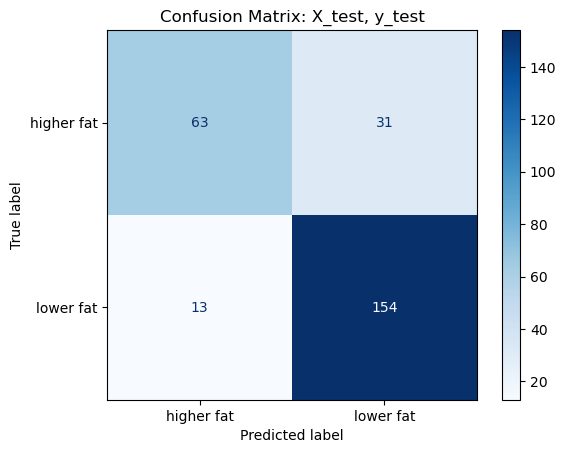

In [62]:
disp = ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, 
                    display_labels = ["higher fat", "lower fat"], values_format = "d",cmap = "Blues")

disp.ax_.set_title('Confusion Matrix: X_test, y_test')

In [63]:
y_test.value_counts()

1    167
0     94
Name: FatLevel, dtype: int64

In [64]:
y_test.value_counts(normalize = True)

1    0.639847
0    0.360153
Name: FatLevel, dtype: float64

###
### Accuracy, Precision, Recall and f1 - RandomForestClassifier

Lets review other metrics for our model and test data.

In [65]:
pred_cv =  pipe.predict(X_test) 
data = {}
data["accuracy"] = np.round([accuracy_score(y_test, pred_cv)], 4)
data["error"] = np.round([1 - accuracy_score(y_test, pred_cv)], 4)
data["precision"] = np.round([precision_score(y_test, pred_cv, zero_division=1)], 4)
data["recall"] = np.round([recall_score(y_test, pred_cv)], 4)
data["f1 score"] = np.round([f1_score(y_test, pred_cv)], 4)
data
measures_df = pd.DataFrame(data, index = ['Scores'])
measures_df

,accuracy,error,precision,recall,f1 score
Scores,0.8314,0.1686,0.8324,0.9222,0.875


###
### Classification report - RandomForestClassifier

Classification report for our model and test data using the weighted average.

**Precision** — What percent of your predictions were correct?  83%

**Recall** — What percent of the positive cases did you catch? 83%

**f1 score** — What percent of positive predictions were correct? 82%




In [66]:
pipe.classes_

array([0, 1])

In [67]:
class_report = classification_report(y_test, pipe.predict(X_test), 
                                     target_names = ["higher fat", "lower fat"])

print(class_report)

              precision    recall  f1-score   support

  higher fat       0.83      0.67      0.74        94
   lower fat       0.83      0.92      0.88       167

    accuracy                           0.83       261
   macro avg       0.83      0.80      0.81       261
weighted avg       0.83      0.83      0.83       261



###
### Classification report - DecisionTreeClassifier

Classification report for our model and test data using the weighted average.

**Precision** — What percent of your predictions were correct? 79%

**Recall** — What percent of the positive cases did you catch? 79%

**f1 score** — What percent of positive predictions were correct? 79%

In [68]:
pipe = make_pipeline(preprocessor, DecisionTreeClassifier(class_weight = 'balanced'))
scores = cross_validate(pipe, X_train, y_train, cv = 5, return_train_score = True)
pd.DataFrame(scores).mean()
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train)

0.9923175416133163

In [69]:
pipe.predict(X_train) 
pipe.score(X_test, y_test)

0.7969348659003831

In [70]:
class_report = classification_report(y_test, pipe.predict(X_test), 
                                     target_names = ["higher fat", "lower fat"])

print(class_report)

              precision    recall  f1-score   support

  higher fat       0.73      0.70      0.71        94
   lower fat       0.84      0.85      0.84       167

    accuracy                           0.80       261
   macro avg       0.78      0.78      0.78       261
weighted avg       0.80      0.80      0.80       261



#
# Appendix: New Exercise

## Text Columns Analysis

### Here we use only the text columns to predict the fat levels.

We combined CountVectorizer() and a model and analyzed against different text columns.

**Models** tested:
- LogisticRegression
- SVC
- KNeighborsClassifier
- RandomForestClassifier
- DecisionTreeClassifier

####
**Text columns** tested: 
- 'CharacteristicsEn',
- 'CheeseName',
- 'FlavourEn',
- 'CharacteristicsEn_CheeseName',
- 'CharacteristicsEn_FlavourEn',
- 'CheeseName_FlavourEn',
- 'CharacteristicsEn_CheeseName_FlavourEn'


In [71]:
X = cheese.drop(columns = 'FatLevel')
y = cheese['FatLevel']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, random_state = 123) 

In [72]:
vec = CountVectorizer()
fig_num = 0

for model in [SVC(), LogisticRegression(class_weight = 'balanced'), 
              KNeighborsClassifier(), DecisionTreeClassifier(class_weight = 'balanced'), 
              RandomForestClassifier(class_weight = 'balanced')]:
    for text_field in text_columns_combined:
        fig_num += 1 
        X_train_subset = X_train[text_field]
        X_test_subset = X_test[text_field]
        
        X_counts = vec.fit_transform(X_train_subset)
        pipe = make_pipeline(CountVectorizer(), model)
        pipe.fit(X_train_subset, y_train)
        pipe.predict(X_train_subset)
        model_train_score = pipe.score(X_train_subset, y_train)
        model_test_score = pipe.score(X_test_subset, y_test)
        scores = cross_validate(pipe, X_train_subset, y_train, cv = 5, return_train_score = True)
        display(pd.DataFrame([pd.DataFrame(scores).mean()]).style.set_caption("Fig " + str(fig_num) 
                + ": " + str(model)  + " Scores for " + text_field))


,fit_time,score_time,test_score,train_score
0,0.011705,0.002862,0.701674,0.811460


,fit_time,score_time,test_score,train_score
0,0.014920,0.002766,0.745174,0.888606


,fit_time,score_time,test_score,train_score
0,0.013572,0.003330,0.683750,0.813381


,fit_time,score_time,test_score,train_score
0,0.021686,0.004808,0.736232,0.892444


,fit_time,score_time,test_score,train_score
0,0.021439,0.005128,0.704214,0.846030


,fit_time,score_time,test_score,train_score
0,0.023258,0.004956,0.732378,0.880283


,fit_time,score_time,test_score,train_score
0,0.029876,0.006764,0.734926,0.890208


,fit_time,score_time,test_score,train_score
0,0.006320,0.000755,0.587686,0.693660


,fit_time,score_time,test_score,train_score
0,0.007605,0.000773,0.746505,0.969591


,fit_time,score_time,test_score,train_score
0,0.007246,0.000886,0.627331,0.778172


,fit_time,score_time,test_score,train_score
0,0.009704,0.001090,0.738796,0.977595


,fit_time,score_time,test_score,train_score
0,0.010217,0.001122,0.663253,0.879004


,fit_time,score_time,test_score,train_score
0,0.010387,0.001002,0.717067,0.975672


,fit_time,score_time,test_score,train_score
0,0.021194,0.001265,0.709350,0.983993


,fit_time,score_time,test_score,train_score
0,0.002417,0.003736,0.674784,0.743597


,fit_time,score_time,test_score,train_score
0,0.002473,0.003524,0.727209,0.782659


,fit_time,score_time,test_score,train_score
0,0.002596,0.004005,0.641507,0.737198


,fit_time,score_time,test_score,train_score
0,0.003534,0.003929,0.676090,0.794166


,fit_time,score_time,test_score,train_score
0,0.003538,0.004103,0.626082,0.752244


,fit_time,score_time,test_score,train_score
0,0.003502,0.003636,0.688837,0.778806


,fit_time,score_time,test_score,train_score
0,0.004223,0.003980,0.644023,0.782649


,fit_time,score_time,test_score,train_score
0,0.004351,0.000719,0.563392,0.750318


,fit_time,score_time,test_score,train_score
0,0.008283,0.000778,0.755479,0.999039


,fit_time,score_time,test_score,train_score
0,0.004494,0.000725,0.606786,0.853407


,fit_time,score_time,test_score,train_score
0,0.010736,0.000797,0.708076,0.999039


,fit_time,score_time,test_score,train_score
0,0.007630,0.000939,0.629904,0.922539


,fit_time,score_time,test_score,train_score
0,0.009754,0.000851,0.713188,1.000000


,fit_time,score_time,test_score,train_score
0,0.012512,0.001107,0.726000,1.000000


,fit_time,score_time,test_score,train_score
0,0.083542,0.005484,0.610746,0.750318


,fit_time,score_time,test_score,train_score
0,0.115200,0.008719,0.756704,0.998719


,fit_time,score_time,test_score,train_score
0,0.093776,0.006003,0.631120,0.853407


,fit_time,score_time,test_score,train_score
0,0.124097,0.007744,0.754173,0.999039


,fit_time,score_time,test_score,train_score
0,0.102421,0.006142,0.681169,0.921243


,fit_time,score_time,test_score,train_score
0,0.108730,0.006782,0.755447,1.000000


,fit_time,score_time,test_score,train_score
0,0.113999,0.006534,0.755430,1.000000


###
### Conclusions of building a model based only text columns:

- **DecisionTreeClassifier(class_weight = 'balanced')** consistently gives the best train score

- Of the three initial text columns, CheeseName gives the best predictions (**train score = 0.997 and test score = 0.755**)


It may be argued that the name given to a cheese was heavily influenced by the other fields and hence is **not a fair** column to predict the fat levels. For that reason we will ignore the CheeseName column.

- If we were to exclude CheeseName then the combined field **CharacteristicsEn_FlavourEn** gave the best predictions (test score =  0.624 and train score = 0.922)


##
### We will proceed with our text based prediction modeling using:
- **imputer (strategy = 'median')**,  
- **DecisionTreeClassifier(class_weight = 'balanced')** and 
- only the combined text field **CharacteristicsEn_FlavourEn**

###

Lets change some of the hyperparameters of CountVectorizer:

- binary = True, had negligible impact  on the scores and the fit and score times. As our daatset is small we will use the default value
- max_features = 10, gave lower scores but the fit and score times were halved. As we only have a small dataset we will use the default value. 

We will continue our analysis using the default values for hyperparameters of CountVectorizer


In [73]:
X = cheese.drop(columns = 'FatLevel')
y = cheese['FatLevel']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, random_state = 123)


In [74]:
pipe = make_pipeline(CountVectorizer(), DecisionTreeClassifier(class_weight = 'balanced'))
pipe.fit(X_train['CharacteristicsEn_FlavourEn'], y_train);

pipe.predict(X_train['CharacteristicsEn_FlavourEn'])
scores = cross_validate(pipe, X_train['CharacteristicsEn_FlavourEn'], y_train, cv = 5, return_train_score = True)
scores_df = pd.DataFrame(scores)
display(scores_df)
display(pipe.score(X_train['CharacteristicsEn_FlavourEn'], y_train))
display(pipe.score(X_test['CharacteristicsEn_FlavourEn'],y_test))

,fit_time,score_time,test_score,train_score
0,0.008116,0.000964,0.675159,0.935897
1,0.007681,0.001095,0.621795,0.896000
2,0.007959,0.000913,0.666667,0.937600
3,0.008006,0.000808,0.570513,0.897600
4,0.007375,0.000838,0.653846,0.945600


0.93854033290653

0.6475095785440613

In [75]:
pipe = make_pipeline(CountVectorizer(binary = True), DecisionTreeClassifier(class_weight = 'balanced'))
pipe.fit(X_train['CharacteristicsEn_FlavourEn'], y_train);

pipe.predict(X_train['CharacteristicsEn_FlavourEn'])
scores = cross_validate(pipe, X_train['CharacteristicsEn_FlavourEn'], y_train, cv = 5, return_train_score = True)
scores_df = pd.DataFrame(scores)
display(scores_df)
display(pipe.score(X_train['CharacteristicsEn_FlavourEn'], y_train))
display(pipe.score(X_test['CharacteristicsEn_FlavourEn'],y_test))

,fit_time,score_time,test_score,train_score
0,0.008161,0.001129,0.681529,0.935897
1,0.007807,0.001073,0.660256,0.896000
2,0.008476,0.000999,0.641026,0.937600
3,0.007749,0.000860,0.596154,0.897600
4,0.007889,0.000958,0.621795,0.945600


0.93854033290653

0.6091954022988506

In [76]:
pipe = make_pipeline(CountVectorizer(max_features = 10), DecisionTreeClassifier(class_weight = 'balanced'))
pipe.fit(X_train['CharacteristicsEn_FlavourEn'], y_train);

pipe.predict(X_train['CharacteristicsEn_FlavourEn'])
scores = cross_validate(pipe, X_train['CharacteristicsEn_FlavourEn'], y_train, cv = 5, return_train_score = True)
scores_df = pd.DataFrame(scores)
display(scores_df)
display(pipe.score(X_train['CharacteristicsEn_FlavourEn'], y_train))
display(pipe.score(X_test['CharacteristicsEn_FlavourEn'],y_test))

,fit_time,score_time,test_score,train_score
0,0.004276,0.000933,0.579618,0.7500
1,0.004701,0.000921,0.621795,0.7584
2,0.003992,0.000847,0.596154,0.7552
3,0.004243,0.000872,0.493590,0.6688
4,0.004435,0.000859,0.512821,0.6800


0.6606914212548015

0.5019157088122606

###

Let's rerun our model using **CountVectorizer()** and **DecisionTreeClassifier** on the **CharacteristicsEn_FlavourEn** text column.

In [77]:
pipe = make_pipeline(CountVectorizer(), DecisionTreeClassifier(class_weight = 'balanced'))
pipe.fit(X_train['CharacteristicsEn_FlavourEn'], y_train);

pipe.predict(X_train['CharacteristicsEn_FlavourEn'])
scores = cross_validate(pipe, X_train['CharacteristicsEn_FlavourEn'], y_train, cv = 5, return_train_score = True)
scores_df = pd.DataFrame(scores)
display(scores_df.mean())
display(pipe.score(X_train['CharacteristicsEn_FlavourEn'], y_train))
display(pipe.score(X_test['CharacteristicsEn_FlavourEn'],y_test))

fit_time       0.008295
score_time     0.001085
test_score     0.644006
train_score    0.922539
dtype: float64

0.93854033290653

0.6743295019157088

###
### Results  based on 

- **imputer (strategy = 'median')**,  
- **DecisionTreeClassifier(class_weight = 'balanced')** and 
- only the combined text field **CharacteristicsEn_FlavourEn**

are:
    
    train score = 0.9385 and test score = 0.6207

###
### Confusion Matrix (Only text columns model)

Lets see how our classification model performs on our test data (**X_test, y_test**) using a 
confusion matrix

[Reference: Adding title to Confusion Matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

Text(0.5, 1.0, 'Confusion Matrix: X_test, y_test')

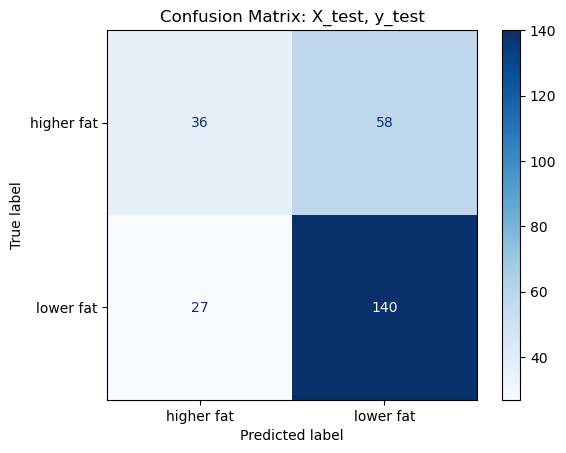

In [78]:
disp = ConfusionMatrixDisplay.from_estimator(pipe, X_test['CharacteristicsEn_FlavourEn'], y_test, 
                    display_labels = ["higher fat", "lower fat"], values_format = "d",cmap = "Blues")

disp.ax_.set_title('Confusion Matrix: X_test, y_test')

In [79]:
y_test.value_counts()

1    167
0     94
Name: FatLevel, dtype: int64

In [80]:
y_test.value_counts(normalize = True)

1    0.639847
0    0.360153
Name: FatLevel, dtype: float64

###
### Accuracy, Precision, Recall and f1 (Only text columns model)

Lets review other metrics for our model and test data.

In [81]:
pred_cv =  pipe.predict(X_test['CharacteristicsEn_FlavourEn']) 
data = {}
data["accuracy"] = np.round([accuracy_score(y_test, pred_cv)], 4)
data["error"] = np.round([1 - accuracy_score(y_test, pred_cv)], 4)
data["precision"] = np.round([precision_score(y_test, pred_cv, zero_division=1)], 4)
data["recall"] = np.round([recall_score(y_test, pred_cv)], 4)
data["f1 score"] = np.round([f1_score(y_test, pred_cv)], 4)
data
measures_df = pd.DataFrame(data, index = ['Scores'])
measures_df

,accuracy,error,precision,recall,f1 score
Scores,0.6743,0.3257,0.7071,0.8383,0.7671


###
### Classification report (only text columns model)

Classification report for our model and test data using the weighted average.

**Precision** — What percent of your predictions were correct?  64%

**Recall** — What percent of the positive cases did you catch? 66%

**F1 score** — What percent of positive predictions were correct? 64%




In [82]:
pipe.classes_

array([0, 1])

In [83]:
class_report = classification_report(y_test, pipe.predict(X_test['CharacteristicsEn_FlavourEn']), 
                                     target_names = ["higher fat", "lower fat"])

print(class_report)

              precision    recall  f1-score   support

  higher fat       0.57      0.38      0.46        94
   lower fat       0.71      0.84      0.77       167

    accuracy                           0.67       261
   macro avg       0.64      0.61      0.61       261
weighted avg       0.66      0.67      0.66       261



## References

1. [UBC: Introduction to Machine Learning Course Notes](https://intro-machine-learning.netlify.app)
2. UBC: Introduction to Machine Learning course assignments and exercises
3. [UBC: Data Visualization Course Notes](https://viz-learn.mds.ubc.ca), for visualizations
4. [scikitllearn Dcumentation](https://scikit-learn.org/stable/) Documentation for sklearn
5. [Tutorial: Article on how to build a text classifier with Logistic Regression](https://kavita-ganesan.com/news-classifier-with-logistic-regression-in-python/#.XT9-xZNKhgc) to understand CountVectorizer
6. [Pretty_Info](https://stackoverflow.com/questions/70748529/how-to-save-pandas-info-function-output-to-variable-or-data-frame) Used this to create pretty_info function



